In [1]:
# Original Code Template by Stephen Siemonsma

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append("..")
sys.path.append("../DiffJPEG")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as T
from abc import ABC, abstractmethod
from torchvision.datasets.vision import VisionDataset
from typing import Callable, cast, List, Optional, Tuple, Union
from pathlib import Path
from glob import glob
from torchvision.datasets.utils import _read_pfm, download_and_extract_archive, verify_str_arg
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from DiffJPEG import DiffJPEG
from modules import compress_jpeg, decompress_jpeg
from utils import diff_round, quality_to_factor
import math
from tqdm import tqdm
from torchvision import datasets
import random
import time
import functools
from torchvision import transforms
from torch.nn import Module

In [2]:
_read_pfm_file = functools.partial(_read_pfm, slice_channels=1)  # For reading PFM (Portable FloatMap) files from FlyingThings3D dataset

In [3]:
# Modified version of a PyTorch dataloader
class MonkaaDataset(ABC, VisionDataset):
    """Base interface for Stereo matching datasets"""

    _has_built_in_disparity_mask = False

    def __init__(self, root: str, train_or_test: str, validation_or_nonvalidation: str, transforms: Optional[Callable] = None) -> None:
        """
        Args:
            root(str): Root directory of the dataset.
            transforms(callable, optional): A function/transform that takes in Tuples of
                (images, disparities, valid_masks) and returns a transformed version of each of them.
                images is a Tuple of (``PIL.Image``, ``PIL.Image``)
                disparities is a Tuple of (``np.ndarray``, ``np.ndarray``) with shape (1, H, W)
                valid_masks is a Tuple of (``np.ndarray``, ``np.ndarray``) with shape (H, W)
                In some cases, when a dataset does not provide disparities, the ``disparities`` and
                ``valid_masks`` can be Tuples containing None values.
                For training splits generally the datasets provide a minimal guarantee of
                images: (``PIL.Image``, ``PIL.Image``)
                disparities: (``np.ndarray``, ``None``) with shape (1, H, W)
                Optionally, based on the dataset, it can return a ``mask`` as well:
                valid_masks: (``np.ndarray | None``, ``None``) with shape (H, W)
                For some test splits, the datasets provides outputs that look like:
                imgaes: (``PIL.Image``, ``PIL.Image``)
                disparities: (``None``, ``None``)
                Optionally, based on the dataset, it can return a ``mask`` as well:
                valid_masks: (``None``, ``None``)
        """
        super().__init__(root=root)
        self.transforms = transforms  # You can load up the transforms argument with you data augmentation
        self.validation_or_nonvalidation = validation_or_nonvalidation
        self.train_or_test = train_or_test

        self._images = []  # type: ignore
        self._disparities = []  # type: ignore
        
        root = Path(root)

        if train_or_test == "TRAIN":
            left_image_pattern = str(root / "../../Monkaa/frames_cleanpass/TRAINING" / validation_or_nonvalidation / "*/left/*.png")
            left_disparity_pattern = str(root / "../../Monkaa/disparity/TRAINING" / validation_or_nonvalidation / "*/left/*.pfm")
        else:
            left_image_pattern = str(root / "../../Monkaa/frames_cleanpass/TESTING/*/left/*.png")
            left_disparity_pattern = str(root / "../../Monkaa/disparity/TESTING/*/left/*.pfm")
        
        self._disparities += self._scan_pairs(left_disparity_pattern)
        self._images += self._scan_pairs(left_image_pattern)


    def _read_img(self, file_path: Union[str, Path]) -> Image.Image:
        img = Image.open(file_path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

    def _scan_pairs(self, paths_left_pattern: str):
        left_paths = list(sorted(glob(paths_left_pattern)))

        if not left_paths:
            raise FileNotFoundError(f"Could not find any files matching the patterns: {paths_left_pattern}")

        paths = left_paths
        return paths

    # function for reading disparity maps
    def _read_disparity(self, file_path: str) -> Tuple[np.ndarray, None]:
        disparity_map = _read_pfm_file(file_path)
        disparity_map = np.abs(disparity_map)  # Ensure that the disparity is positive
        valid_mask = None
        return disparity_map

    def __getitem__(self, index: int) -> np.ndarray:
        """Return example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            tuple: A 3 or 4-tuple with ``(img_left, img_right, disparity, Optional[valid_mask])`` where ``valid_mask``
                can be a numpy boolean mask of shape (H, W) if the dataset provides a file
                indicating which disparity pixels are valid. The disparity is a numpy array of
                shape (1, H, W) and the images are PIL images. ``disparity`` is None for
                datasets on which for ``split="test"`` the authors did not provide annotations.
        """
        
        # Only used the left disparity map, but we can use either (maybe just randomize it)
        dsp_map_left = self._read_disparity(self._disparities[index])
        img_left = self._read_img(self._images[index])
        
        dsp_maps = torch.from_numpy(dsp_map_left)
        img_maps = torch.from_numpy(np.array(img_left))
        img_maps = img_maps.permute(2, 0, 1) # this reshapes our tensor so we can combine RGB+D
        
        dsp_maps[dsp_maps <= 0] = 1e-6  # In case there are any disparities that equal 0, we need to make them a small positive value so that depth is never calculated as infinity (for depth normalization purposes)
            
        depth_maps = 1 / dsp_maps        
        img_maps = img_maps / 255 # normalize the RGB values to a range [0, 1]
        
        rgbd_map = torch.cat((img_maps, depth_maps), dim=0) # combine RGB + D tensors
        if self.transforms is not None: # perform transforms on ALL 4 channels
            rgbd_map = self.transforms(rgbd_map)
 
        # print(rgbd_map.shape)
        # print("Depth map shape:", depth_maps.shape)
        # print("Image map shape:", img_maps.shape)
        # print("RGB-D map shape:", rgbd_map.shape)
        # print("RGB-D map DATA:", rgbd_map[0][0])

        return rgbd_map

    def __len__(self) -> int:
        return len(self._disparities)

In [4]:
# Implementation found at: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(mid_channels), # remove batch normalization uncomment to see first 2 trainings)
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [107]:
# This is the depth autoencoder model
class NeuralDepthEncoder(nn.Module):
    def __init__(self, height, width, subsampling=True, device=torch.device("mps")):
        super(NeuralDepthEncoder, self).__init__()
        self.device = device
        self.pi = torch.tensor(math.pi)
        
        self.convs1 = nn.Sequential(
            nn.Conv2d(4, 512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 3, kernel_size=1, stride=1, padding=0)
        )
            
        self.convs2 = nn.Sequential(
            nn.Conv2d(3, 512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 4, kernel_size=1, stride=1, padding=0) # 4 output layers: RGB + D
        )
        
        self.JPEG = DiffJPEG(height, width, subsampling)

        # Subclass for the U-Net
        class UNet(nn.Module):
            def __init__(self, n_inputs, n_outputs, bilinear=True):
                super(UNet, self).__init__()
                self.n_inputs = n_inputs
                self.n_outputs = n_outputs
                self.bilinear = bilinear
        
                self.inc = (DoubleConv(n_inputs, 64))
                self.down1 = (Down(64, 128))
                self.down2 = (Down(128, 256))
                factor = 2 if bilinear else 1 # fix for checkerboarding (want to pass True)
                self.down3 = (Down(256, 512 // factor))
                self.up1 = (Up(512, 256 // factor, bilinear))
                self.up2 = (Up(256, 128 // factor, bilinear))
                self.up3 = (Up(128, 64, bilinear))
                self.outc = (OutConv(64, n_outputs))
        
            def forward(self, x):
                x1 = self.inc(x)
                x2 = self.down1(x1)
                x3 = self.down2(x2)
                x4 = self.down3(x3)
                x = self.up1(x4, x3)
                x = self.up2(x, x2)
                x = self.up3(x, x1)
                logits = self.outc(x)
                return logits
        
            def use_checkpointing(self):
                self.inc = torch.utils.checkpoint(self.inc)
                self.down1 = torch.utils.checkpoint(self.down1)
                self.down2 = torch.utils.checkpoint(self.down2)
                self.down3 = torch.utils.checkpoint(self.down3)
                self.up1 = torch.utils.checkpoint(self.up1)
                self.up2 = torch.utils.checkpoint(self.up2)
                self.up3 = torch.utils.checkpoint(self.up3)
                self.outc = torch.utils.checkpoint(self.outc)

        # UNet for ENCODING (4 inputs, 3 outputs)
        self.unetEncoder = UNet(4, 3)
        
        # UNet for DECODING (3 inputs, 4 outputs)
        self.unetDecoder = UNet(3, 4)
    
    def forward(self, x, quality, differentiable_rounding=True, use_JPEG=True):
        neural_encoding = torch.zeros([x.shape[0], 4, x.shape[2], x.shape[3]], device=self.device)
        neural_encoding = self.convs1(x)
        unet_encoding = self.unetEncoder(x)

        # Add encoded tensors
        combined_encoding = neural_encoding + unet_encoding

        sigmoid_activation = nn.Sigmoid()
        combined_encoding = sigmoid_activation(combined_encoding)

        # display neural encoded RGB image
        # image = combined_encoding.clone()
        # image = image.squeeze().permute(1,2,0)
        # plt.imshow(image.detach().cpu().numpy())
        # plt.title('Neural-Encoded RGB Image')
        # plt.axis('off')  # Remove axes for better visualization
        # plt.show()
        
        if differentiable_rounding:
            neural_encoding = diff_round(combined_encoding * 255) / 255
        else:
            neural_encoding = torch.round(combined_encoding * 255) / 255
        
        if use_JPEG:
            JPEG_compressed = self.JPEG(combined_encoding, quality, differentiable_rounding)
        else:
            JPEG_compressed = combined_encoding
        
        recovered_depth_and_color = self.convs2(JPEG_compressed)
        unet_decoding = self.unetDecoder(JPEG_compressed)

        # add decoded tensors
        combined_encoding = recovered_depth_and_color + unet_decoding

        # Recovered r,g,b,d here
        recovered_depth = combined_encoding[:, 3, :, :].reshape([x.shape[0], 1, x.shape[2], x.shape[3]]) # return index 3 for depth values
        recovered_color = combined_encoding[:, :3, :, :].reshape([x.shape[0], 3, x.shape[2], x.shape[3]]) # return the indices 0,1,2
    
        return recovered_depth, recovered_color

In [108]:
class AddGaussianNoise(Module): # function for our transform to add gaussian noise to the training dataset
    """Adds Gaussian noise to a tensor."""
    
    def __init__(self, mean=0., std=1.):
        super(AddGaussianNoise, self).__init__()
        self.mean = mean
        self.std = std
    
    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [109]:
batch_size = 1
valid_proportion = 0.2
height = 224 # resize from 960x540
width = 224

# Transformations for the training set here, randomcrop and gaussian noise gave us the best results
transforms = T.Compose([
    T.RandomCrop((height, width)),  # Randomly crops the images
    # T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Adds color jitter
    AddGaussianNoise(0., 0.01),  # Adds Gaussian noise with a standard deviation of 0.1
])

# Load nonvalidation training set
dataset = MonkaaDataset("", "TRAIN", "NONVALIDATION", transforms)

# we don't want to add gaussian noise or randomcrops to the validation & test data
transforms = T.Compose([
    T.CenterCrop((224, 224)),  # crops the images (not random)
])

# load validation set
valid_set = MonkaaDataset("", "TRAIN", "VALIDATION", transforms)

# Put the datasets in the dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)  # Would use train_set instead of "dataset" if doing proper train/valid split
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)

In [110]:
device = torch.device("mps")  # For M-series Macs
#device = torch.device("cpu")  # For slow training on CPU
#device = torch.device("cuda")  # For NVIDIA cards
# net = NeuralDepthEncoder(height, width, subsampling=True).to(device)
net = NeuralDepthEncoder(height, width, subsampling=False).to(device)
net.JPEG.requires_grad_(False)  # VERY IMPORTANT TO INCLUDE: DiffJPEG includes some parameters that could be "trained", which would give the illusion of good results (but you'd really just be cheating and not using JPEG)

DiffJPEG(
  (compress): compress_jpeg(
    (l1): Sequential(
      (0): rgb_to_ycbcr_jpeg()
      (1): chroma_subsampling()
    )
    (l2): Sequential(
      (0): block_splitting()
      (1): dct_8x8()
    )
    (c_quantize): c_quantize()
    (y_quantize): y_quantize()
  )
  (decompress): decompress_jpeg(
    (c_dequantize): c_dequantize()
    (y_dequantize): y_dequantize()
    (idct): idct_8x8()
    (merging): block_merging()
    (chroma): chroma_upsampling()
    (colors): ycbcr_to_rgb_jpeg()
  )
)

In [111]:
test_dataset = MonkaaDataset("", "TESTING", "", transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [113]:
num_training_epochs = 100
starting_lr = 1e-3
lr_gamma = 0.5   # (for both fixed and metric-based scheduler) This is the factor the learning rate decreases by after the metric doesn't improve for some time
patience = 1    # (for metric-based scheduler only) The number of iterations that must pass without metric improvement for the learning rate to decrease
step_size = 20   # (for fixed scheduler only) After this many epochs, the learning rate is decreased
weight_decay = 1e-5  # IMPORTANT: we probably actually want this to be a small-non-zero value for model weight regularization purposes
optimizer = optim.Adam(net.parameters(), lr=starting_lr, weight_decay=weight_decay)
#optimizer = optim.SGD(net.parameters(), lr=starting_lr, momentum=0.9, weight_decay=weight_decay, nesterov=False)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_gamma, patience=patience, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-10)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_gamma, patience=patience, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-10)

# This is a really cool learning rate scheduler, but we could see it resulting in overfitting for a model that is succeptible to that
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5066, 1)

MSE_criterion = nn.MSELoss()
L1_criterion = nn.L1Loss()
BCE_criterion = nn.BCEWithLogitsLoss()

In [115]:
# Useful if you want to check on the current learning rate (due to use of learning rate schedulers)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [116]:
best_val_loss = torch.inf
best_max_val_loss = torch.inf
best_avg_L1_loss = torch.inf
best_avg_RMSE_loss = torch.inf
best_validation_loss = torch.inf

In [117]:
# Test model on validation data
def validate_model(model, validation_loader, criterion):
    total_loss = 0.0
    total_samples = 0

    validation_progress_bar = tqdm(validation_loader, position=0)

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, depth_maps in enumerate(validation_progress_bar):
            depth_maps = depth_maps.to(device)
            
            # Forward pass
            recovered_depth, recovered_color = model(depth_maps, quality, True, True)
            
            # Compute loss
            depth_loss = criterion(recovered_depth, depth_maps[0, 3, :, :])
            color_loss = criterion(recovered_color, depth_maps[0, :3, :, :])
            combined_loss = depth_loss + color_loss
            
            # Accumulate total loss
            total_loss += combined_loss.item() * depth_maps.size(0)
            total_samples += depth_maps.size(0)
            
            validation_progress_bar.set_description('Validation Training %i' % (i+1)) 
            validation_progress_bar.set_postfix_str('Validation Loss: %.4f' % (total_loss/(i+1))) # display the avg MSE loss

    # Calculate average loss
    average_loss = total_loss / total_samples
    return average_loss


In [122]:
# Note: This JPEG quality training range is somewhat arbitrary.
# If you use a rate-distortion loss (like the Google paper), you can remove all of the loss normalization steps that I take in this template.
# low_quality = 85
# high_quality = 99.999
low_quality = 90 # using same qualities for our case
high_quality = 90

L1_loss_weighting = 6
background_loss_weighting = 0.03
#depth_maps_orig = None

training_losses = []
validation_losses = []

for j in range(num_training_epochs):
    progress_bar = tqdm(train_loader, position=0)

    RMSE_quality_normalization_factor = None
    L1_quality_normalization_factor = None
    acc_MSE_loss = 0
    acc_RMSE_loss = 0
    
    for i, depth_maps in enumerate(progress_bar):
        #depth_maps_orig = depth_maps.clone()  # Be careful about references and create deep copies when needed
        
        quality = random.uniform(low_quality, high_quality)
        
        optimizer.zero_grad()

        # mask = mask.to(device) # DELETE?
        depth_maps = depth_maps.to(device) # this tensor contains RGB+D

        recovered_depth, recovered_color = net(depth_maps, quality, True, True)
        
        # Depth losses
        depth_MSE_loss = MSE_criterion(recovered_depth, depth_maps[0,3,:,:])
        depth_L1_loss = L1_criterion(recovered_depth, depth_maps[0,3,:,:])
        depth_RMSE_loss = torch.sqrt(depth_MSE_loss)

        # Color losses
        color_MSE_loss = MSE_criterion(recovered_color, depth_maps[0,:3,:,:])
        color_L1_loss = L1_criterion(recovered_color, depth_maps[0,:3,:,:])
        color_RMSE_loss = torch.sqrt(color_MSE_loss)
        
        combined_loss = depth_MSE_loss + color_MSE_loss

        combined_loss.backward()
        
        optimizer.step()
        # scheduler.step(L1_loss_in_range)  # IMPORTANT IF USING METRIC-BASED SCHEDULER
        scheduler.step()
        acc_MSE_loss += combined_loss.item()
        acc_RMSE_loss += depth_RMSE_loss.item() + color_RMSE_loss.item()
        progress_bar.set_description('Epoch %i Training %i' % (j, i+1))
        progress_bar.set_postfix_str('Training Loss: %.4f' % (acc_RMSE_loss/(i+1))) # display the avg MSE loss
    # scheduler.step(combined_loss)  # IMPORTANT IF USING METRIC-BASED SCHEDULER
        # print(get_lr(optimizer))  # If we want to check on the current learning rate
    # Compute "Validation" losses every epoch
    validation_loss = validate_model(net, valid_loader, MSE_criterion)
    validation_losses.append(validation_loss) # append the validation loss for later plotting
    training_losses.append(acc_MSE_loss / 5066) # append the validation loss for later plotting

    # Check if our current model has the best performance on validation data
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        weights = net.state_dict()
        torch.save(weights, "./weights/colorful_depth_compression_best_MSE_val.weights")

Epoch 0 Training 100:   2%|▏         | 100/5066 [00:10<08:49,  9.38it/s, Training Loss: 0.0399]


KeyboardInterrupt: 

13
13


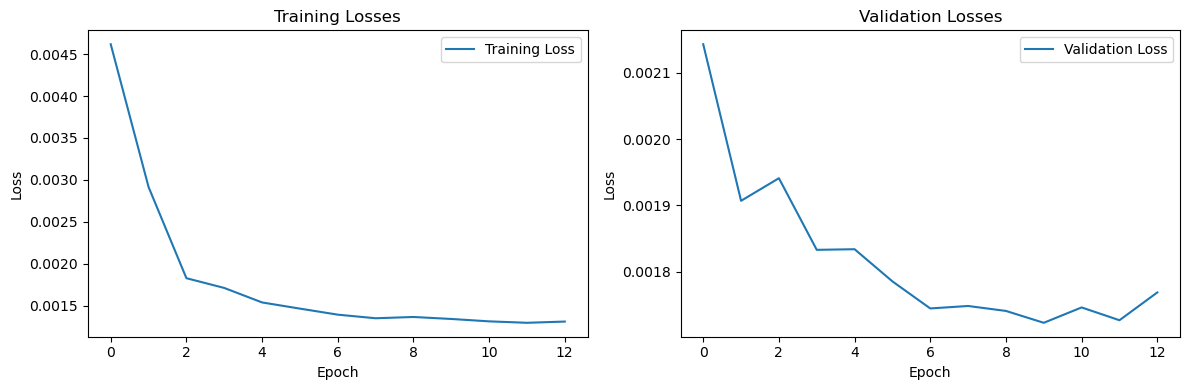

In [121]:
print(len(training_losses))
print(len(validation_losses))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # figsize can be adjusted to your preference

# Plot training losses
axs[0].plot(training_losses, label='Training Loss')
axs[0].set_title('Training Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot validation losses
axs[1].plot(validation_losses, label='Validation Loss')
axs[1].set_title('Validation Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

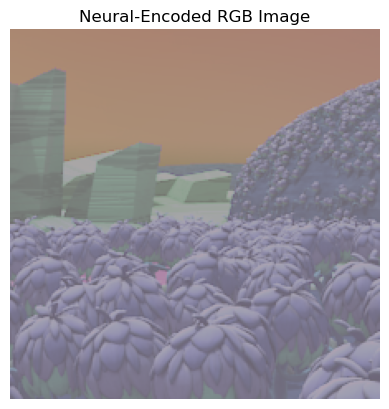

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


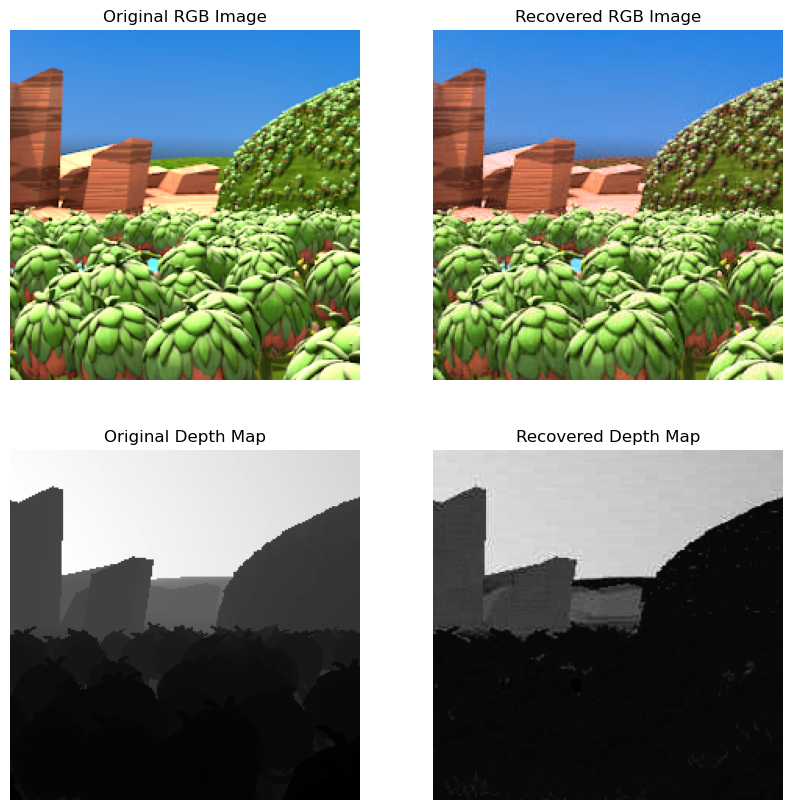

In [97]:
# This cell serves as a test of our net on a random frame input

# load weights saved from training
weights = torch.load("./weights/colorful_depth_compression_best_MSE_val.weights")
# weights = torch.load("./weights/best_MSE_4_withNoise.weights")
net.load_state_dict(weights)
net.eval() # set network to evaluation mode

#--------------------------------------------------------------------------------------------------------
depth_maps = test_dataset[1100].reshape([1, 4, 224, 224]) # NEED to reshape to a different dimension

# run it through the network
depth_maps = depth_maps.to(device) # this tensor contains RGB+D
original_depth_map = torch.clone(depth_maps)
recovered_depth, recovered_color = net(depth_maps, quality, True, True)

# reconstruct RGB-D from our recovered data
depth_maps = torch.cat((recovered_depth, recovered_color), dim=1) # combine RGB + D tensors

#--------------------------------------------------------------------------------------------------------

# Prepare 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display the original RGB image
original_rgb = np.transpose(original_depth_map[0,:3,:,:].detach().cpu().numpy(), (1, 2, 0))
axs[0, 0].imshow(original_rgb)
axs[0, 0].set_title('Original RGB Image')
axs[0, 0].axis('off')  # Hide axes ticks

# Display the recovered RGB image
recovered_rgb = np.transpose(recovered_color[0,:,:,:].detach().cpu().numpy(), (1, 2, 0))
axs[0, 1].imshow(recovered_rgb)
axs[0, 1].set_title('Recovered RGB Image')
axs[0, 1].axis('off')

# Original Depth Map
original_depth_map = original_depth_map[0,3,:,:].detach().cpu().numpy()
# axs[1, 0].imshow(original_depth_map, cmap='turbo')
axs[1, 0].imshow(original_depth_map, cmap='gray')
axs[1, 0].set_title('Original Depth Map')
axs[1, 0].axis('off')

# Recovered Depth Map
recovered_depth_map = recovered_depth[0,0,:,:].detach().cpu().numpy()
# axs[1, 1].imshow(recovered_depth_map, cmap='turbo')
axs[1, 1].imshow(recovered_depth_map, cmap='gray')
axs[1, 1].set_title('Recovered Depth Map')
axs[1, 1].axis('off')
plt.show()

# display output of _ layer
# plt.imshow(depth_map_for_normalization[0,3,:,:].detach().cpu().numpy().reshape([224,224])) # is the second parameter actually the depth?
# plt.colorbar()



In [103]:
# Evaluate performance over test data
def test_model(model, validation_loader, criterion):
    model.eval()  # Set the model to evaluation mode (Do we need this? It supposedly treats batch normalization and dropout differently)
    total_loss = 0.0
    total_samples = 0

    validation_progress_bar = tqdm(validation_loader, position=0)

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, depth_maps in enumerate(validation_progress_bar):
            depth_maps = depth_maps.to(device)
            
            # Forward pass
            recovered_depth, recovered_color = model(depth_maps, quality, True, True)
            
            # Compute loss
            depth_loss = criterion(recovered_depth, depth_maps[0, 3, :, :])
            color_loss = criterion(recovered_color, depth_maps[0, :3, :, :])
            combined_loss = depth_loss + color_loss
            
            # Accumulate total loss
            total_loss += combined_loss.item() * depth_maps.size(0)
            total_samples += depth_maps.size(0)
            
            validation_progress_bar.set_description('Testing %i' % (i+1)) 
            validation_progress_bar.set_postfix_str('Testing Loss: %.4f' % (total_loss/(i+1))) # display the avg MSE loss

    # Calculate average loss
    average_loss = total_loss / total_samples
    return average_loss

weights = torch.load("./weights/colorful_depth_compression_best_MSE_val.weights")
# weights = torch.load("./weights/best_MSE_4_withNoise.weights")
net.load_state_dict(weights)
print(test_model(net, test_loader, MSE_criterion))



Testing 1594: 100%|██████████| 1594/1594 [01:36<00:00, 16.50it/s, Testing Loss: 0.0010]

0.0009686917993478148


In [130]:
# Save final model, too, if you want, but it probably won't be the best
weights = net.state_dict()
torch.save(weights, "./weights/colorful_depth_compression_ending.weights")